# Supply Chain Optimization using MIS Demo
---

**NOTE: [Jump](#exec) to skip description:**

The supply chain optimization problem can be formulated as a *travel plan* scheduling problem utilizing the power of TigerGraph Graph database in the following way.

- There are a fixed number of trucks
- Each travel plan is assigned a truck (not necessarily unique)
- Number of trucks << Number of travel plans
- There are a fixed number of work orders to be completed
- Each travel plan is associated with one or more work orders
- A work order might need more than 1 trip to be completed
- Number of work orders << Number of travel plans

Finally, the resource conflict is modelled as:

 - **If two travel plans share a truck or a work order, they can not be executed at the same time**

### Problem Formulation

In this example, the goal is to execute all travel plans in the least amount of time. To accomplish this, it can be stated that for a list of travel plans that are yet to be scheduled, we need to find the maximum number of travel plans that can be scheduled at the same time, given the set of available trucks and work orders to complete. When a set of scheduled travel plans are finished, the process is repeated until all travel plans are executed.

Travel plans, trucks, work orders and their relationships can be easily captured by creating a TigerGraph graph database. Consider a scenario with 3 travel plans, 2 trucks and 2 work orders. The travel plans have dependencies on trucks and work orders as shown in the following figure:

<img src="https://xilinx.github.io/graphanalytics/_images/mis-depen-graph.png" width=200 height=200 />


Truck *tr0* is used in trips *tp0* and *tp2* while truck *tr1* is used only in trip *tp1*. Similarly, work order
*wo0* is part of only trip *tp0* while work order *wo1* is split between trips *tp1* and *tp2*. These dependencies create conflicts such that travel plans *tp0* and *tp2* can not be executed at the same time. This relationship is captured in a travel plans conflict graph as shown below where travel plans are represented as vertices and are connected by an edge if there is a schedule conflict between them.

<img src="https://xilinx.github.io/graphanalytics/_images/mis-tp-graph.png" width=140 height=140 />

TigerGraph allows creation of the conflict graph easily by writing queries in GSQL. New edges are created in the original graph so that traversal can be done only on travel plan to travel plan edges while computing the MIS.

### MIS Formulation

After a conflict graph is obtained like above, the supply chain optimization problem can be modelled as an MIS problem on the conflict graph: Given the conflict graph of travel plans yet to be scheduled, find the MIS of the graph to obtain set of travel plans that can be scheduled at the same time. Execute the obtained MIS travel plans, remove vertices and edges associated to them from the conflict graph, and run MIS on the remaining sub-graph. This is continued till the graph is empty as summarized below:

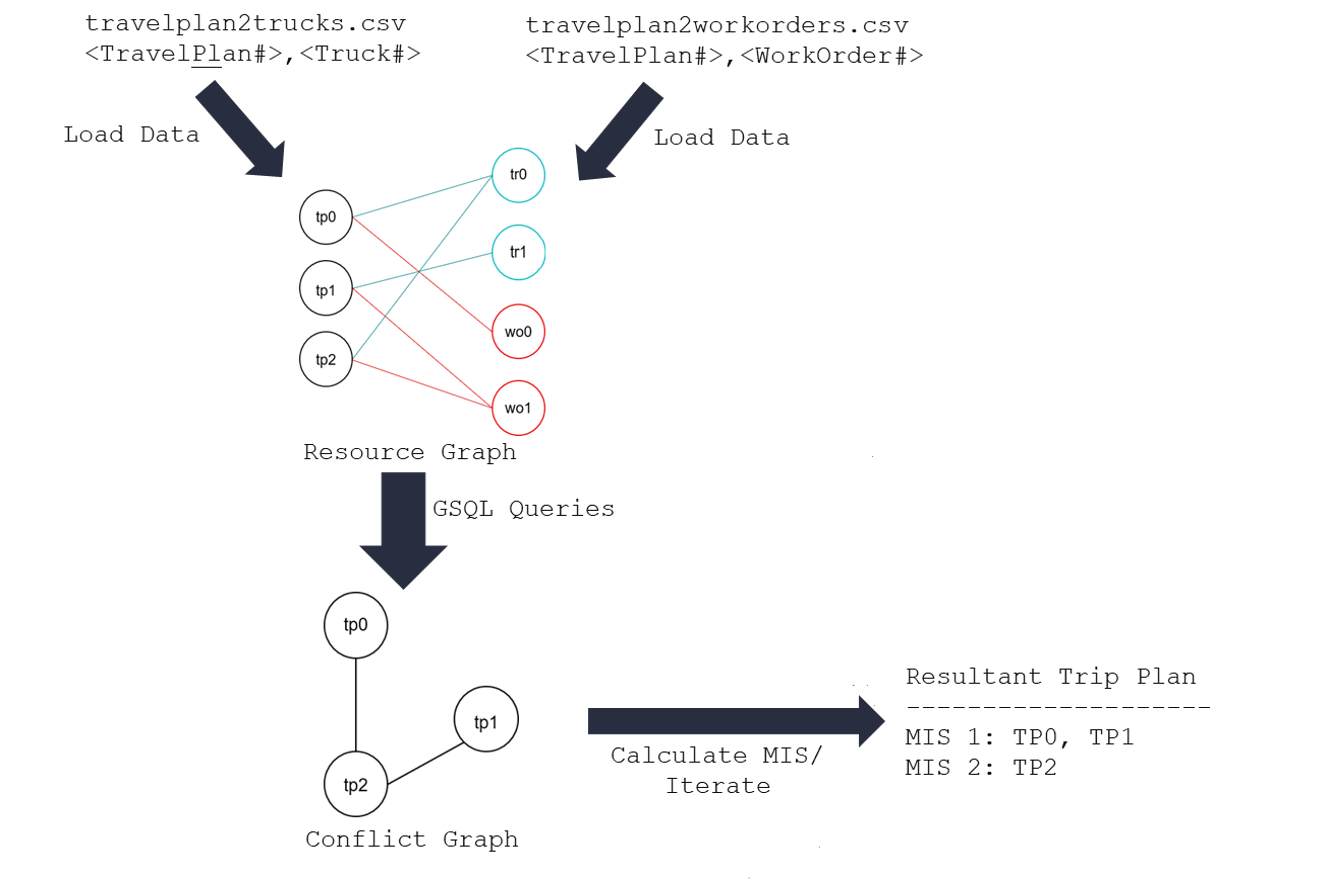

[//]: # (<img src="https://xilinx.github.io/graphanalytics/_images/mis-summary.png" width=140 height=140 />)

Here we end up with two schedules of size 2 (*tp0*, *tp1*) and size 1 (*tp2*), which is the optimal schedule given only 2 trucks available.

Lastly, if a maximal set is used instead of the maximum set, the scheduling will not be optimal. The Xilinx Maximal Independent Set library produces high “quality” (close to maximum) sets which can achieve close to optimal results for all practical purposes.

The next sections show how to create a TigerGraph Database and use the Xilinx Maximal Independent Set plugin to accelerate MIS computation.

This notebook uses [pyTigerGraph](https://pytigergraph.github.io/pyTigerGraph/), a TigerGraph python interface to run gsql queries on a remote server running TigerGraph via Rest APIs.

### Setup
---
Boilerplate module imports

In [ ]:
import time
from pathlib import Path, PurePosixPath
import pyTigerGraph as tg

#### Login Setup
Provide the remote TigerGraph server URL/IP address/hostname and credentials for a TigerGraph user. 

**NOTE**: The TigerGraph user should be created on the server side before proceeding

In [ ]:
hostName = "localhost"                              # TG server hostname
userName = "tigergraph"                             # TG user name
passWord = "tigergraph"                             # TG user password

#### Path Setup
**Local**: Location of query files under the Xilinx graphanalytics github repo. Set location of the local repo.

In [ ]:
localRepoLocation = Path("/proj/gdba/sachink/ghe/ga_2")
exampleLocation = Path("graphanalytics/plugin/tigergraph/mis/examples/travelplan/") # when running from github repo
queryFileLocation = localRepoLocation / exampleLocation / "query"

**NOTE**: Data files should exist on the TigerGraph server 

In [ ]:
serverRepoLocation = PurePosixPath("/proj/gdba/sachink/ghe/ga_2")
serverDataLocation = serverRepoLocation / PurePosixPath(exampleLocation) / "data"
tp2woInfile = serverDataLocation / "travelplan2workorders100.csv"
tp2trInfile = serverDataLocation / "travelplan2trucks100.csv"

---
#### Prepare TG database<a id="exec"></a>
Shows **one-time** preparation of the database. Once done, queries can be repeateadly run as shown in the next Section.
1. [**Load Graph**](#loadg)
 - [Create new graph](#newg)
 - [Create graph schema](#schema)
 - [Load graph data](#loadd)
 - [Build Edges](#build_edges)
 - [Install queries](#install)


2. [**Generate CSR**](#csr)


#### Run Queries on FPGA
Shows **repeatable** use of query to run *accelerated* MIS on FPGA

[**Compute MIS**](#run)
1. [TigerGraph Native GSQL MIS](#tg_run)
2. [Xilinx Alveo MIS](#alveo_run)

The cells below show how to perform these steps in detail.

### 1. Load Graph <a id="loadg"></a>
---
#### 1.1 Create new graph <a id="newg"></a>
- Connect to TigerGraph server by ommiting graph name. This is needed to establish a valid REST endpoint that will be used to create a new desired graph
- Create new graph by using gsql command and create a new connection with the new graph

In [ ]:
# connect to TG server and create graph
graphName = f'travelplan_graph_{userName}'   # TG graph name
conn = tg.TigerGraphConnection(host='http://' + hostName, graphname='', username=userName, password=passWord, useCert=False)
print("\n--------- Creating New graph ----------")
print(conn.gsql(f'create graph {graphName}()', options=[]))

# connect to TG server with new graph
print(f'Using graph {graphName}')
conn = tg.TigerGraphConnection(host='http://' + hostName, graphname=graphName, username=userName, password=passWord, useCert=False)

Any command or query will now run on the new graph.

#### 1.2 Create graph schema <a id="schema"></a>
TigerGraph stores graph in the form of vertices that can be associated with other vertices using directed or undirected edges. This is specified in the form of a graph schema. For the purpose of this demo, the schema is already defined as a query file. Load the file, set graph name and run it as gsql commands. 

The following schema will be created after running the next cell:

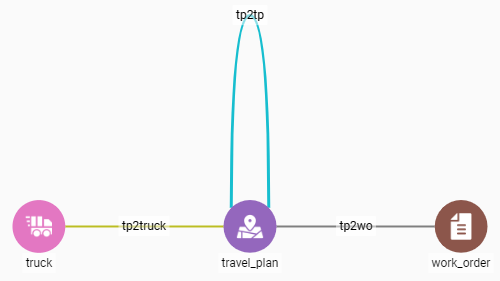

[//]: # (<img src="https://xilinx.github.io/graphanalytics/_images/mis_schema.PNG" width=140 height=140 />)

In [ ]:
print("\n--------- Creating New Schema ----------")
schemaFile = queryFileLocation / "schema.gsql"

with open(schemaFile) as fh:
    qStrRaw = fh.read()
    qStr = qStrRaw.replace('@graph', graphName)
    print(conn.gsql(qStr))
print("\n----------------- Done -----------------")
    
# print a sneak peek of the schema
schema = conn.getSchema(False)
print(f"\nTotal {len(schema['VertexTypes'])} Vertices created:")
i = 1
for v in schema['VertexTypes']:
    print(f" {i}. {v['Name']}")
    i+=1

print(f"\nwith the following edges:")
i = 1
for e in schema['EdgeTypes']:
    print(f" {i}. {e['Name']}: {e['FromVertexTypeName']} - {e['ToVertexTypeName']}")
    i+=1

#### 1.3 Load graph data <a id="loadd"></a>

Next up is populating the graph according to the schema above. Two loading jobs are used to load travel plan to truck and  travel plan to work order relationships respectively.

In [ ]:
print("\n--------- Loading data into graph ----------")
loadFile = queryFileLocation / "load.gsql"

with open(loadFile) as fh:
    qStrRaw = fh.read()
    
    qStr = qStrRaw.replace('@graph', graphName)
    print(conn.gsql(qStr))
    print(conn.gsql(f'USE GRAPH {graphName}\n RUN LOADING JOB load_tp2tr USING tp2tr_infile="{tp2trInfile}"'))
    print(conn.gsql(f"USE GRAPH {graphName}\n DROP JOB load_tp2tr"))
    print(conn.gsql(f'USE GRAPH {graphName}\n RUN LOADING JOB load_tp2wo USING tp2wo_infile="{tp2woInfile}"'))
    print(conn.gsql(f"USE GRAPH {graphName}\n DROP JOB load_tp2wo"))
print("\n------------------- Done -------------------")

#### 1.4 Build edges <a id="build_edges"></a>

As seen in the introduction, we need to build new edges that capture conflicts between travel plans. This is done by identifying travel plan vertices to be connected via *tp2tp* edges by performing two hops: travel plan -> work order -> travel plan and travel plan -> truck -> travel plan.

Following cell loads the build_edges query file, installs and runs it.

In [ ]:
print("\n--- Installing and running Build edges query ---")
buildEdgesFile = queryFileLocation / "build_edges.gsql"
with open(buildEdgesFile) as fh:
    qStrRaw = fh.read()
    qStr = qStrRaw.replace('@graph', graphName)
    print(conn.gsql(qStr))

print('Building edges for travelplan vertices\n'+'-'*38)

result = conn.runInstalledQuery('build_edges', timeout=240000000)
for res in result:
    for k in res:
            print(k, ":", res[k])

print('Waiting for Graph to stabilize...')
tp2tp_edges = 0
while(True):
    time.sleep(10)
    edges = conn.getEdgeCountFrom(edgeType='tp2tp')
    if(edges == tp2tp_edges):
        break
    tp2tp_edges = edges
print('Done!')

#### 1.5 Install queries <a id="install"></a>

Now install rest of the queries. This includes TigerGraph's implementation of MIS as well as Xillinx specific queries utilizing UDFs (Note all UDFs are installed as part of the MIS plugin and demo plugin).

In [ ]:
print("\n--------- Installing Queries ----------")
queryFiles = [queryFileLocation / "tg_supply_chain_schedule.gsql",
              queryFileLocation / "xlnx_supply_chain_schedule.gsql"]

for qf in queryFiles:
    with open(qf) as fh:
        print(f"installing queries in {qf}...")
        qStrRaw = fh.read()
        qStr = qStrRaw.replace('@graph', graphName)
        print(conn.gsql(qStr))

print("\n--------- All queries installed ----------")

#### Graph Data Overview
 
TigerGraph allows to check for some basic statistics about the graph in the following way:
(Note: the edge and vertex functions return correct results only after the graph has had time to "stabilize")

In [ ]:
# Get Graph Statistics
print("\n--------- Graph Overview ----------")
total_vertices = conn.getVertexCount('*')
print(f"\nTotal Vertices:")
for v in total_vertices:
    print(f"  {v}: {total_vertices[v]}")

print(f"\nTotal Edges:")
total_edges = conn.getEdgeCountFrom(edgeType='*')
for e in total_edges:
    print(f"  {e}: {total_edges[e]}")

Now that queries are installed, rest of the operations can be performed simply by running the queries as follows.

### 2. Generate CSR <a id="csr"></a>
---

In [ ]:
tStart = time.perf_counter()
print('Assign unique IDs to Travel Plan vertices\n'+'-'*41)
result = conn.runInstalledQuery('assign_ids', {'v_type': "travel_plan"}, timeout=240000000)
for res in result:
    for k in res:
            print(k, ":", res[k])
            
print('\nBuild Row Ptr and Column Idx arrays\n'+'-'*35)
result = conn.runInstalledQuery('build_csr', {'v_type': "travel_plan", 'e_type': "tp2tp"}, timeout=240000000)
for res in result:
    for k in res:
            print(k, ":", res[k])

print(f'\ncompleted in {time.perf_counter() - tStart:.4f} sec')

This completes the TigerGraph database preparation for MIS runs. We can now run as many MIS queries as we want. 

### Compute MIS <a id="run"></a>
---

### 1. TigerGraph Native GSQL MIS: <a id="tg_run"></a>

In [ ]:
print('Running Queries on TG CPU\n'+'-'*25)
tStart = time.perf_counter()
result = conn.runInstalledQuery('tg_supply_chain_schedule',
                                {'v_type': "travel_plan", 
                                 'e_type': "tp2tp",
                                 'max_iter_per_schedule': 100,
                                 'num_schedule': 0,             # 0 corresponds to all possible schedules
                                 'print_accum': True,
                                 'sched_file_path': "",
                                 'sched_metadata_path': ""},
                                timeout=240000000)
tDuration_cpu = 1000*(time.perf_counter() - tStart)

for res in result:
    for k in res:
        if k == '@@mis_mdata':
            print("Schedule Sizes :", [x['sz'] for x in res[k]])
        else:
            print(k, ":", res[k])
            
    
print(f"\nRound Trip time: {tDuration_cpu:.2f} msec")

### 2. Xilinx Alveo MIS: <a id="alveo_run"></a>

In [ ]:
print('Running Queries on FPGA\n'+'-'*23)
tStart = time.perf_counter()
result = conn.runInstalledQuery('supply_chain_schedule_alveo',
                                {'v_type': "travel_plan", 
                                 'e_type': "tp2tp",
                                 'num_schedule': 0,             # 0 corresponds to all possible schedules
                                 'print_accum': True,
                                 'sched_file_path': "",
                                 'sched_metadata_path': ""},
                                timeout=240000000)
tDuration_alv = 1000*(time.perf_counter() - tStart)

for res in result:
    for k in res:
        if k == '@@mis_mdata':
            print("Schedule sizes :", res[k])
        else:
            print(k, ":", res[k])
    
print(f"\nRound Trip time: {tDuration_alv:.2f} msec")

Speedup Observed above is:

In [ ]:
print(f"Speedup = {tDuration_cpu/tDuration_alv:.2f}X")

Feel free to play with the query!

#### Thanks for your time!